# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar
from coreforecast.scalers import boxcox_lambda, boxcox, inv_boxcox

c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [2]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

In [4]:
#sem variavel exogena
df_daily_filled = df_daily_filled.resample('D').sum()
df_8 = df_daily_filled.filter(['count_8']).reset_index().assign(unique_id = 8)
df_8 = df_8.filter(['unique_id','detected','count_8'])
df_8.columns = ['unique_id','ds','y']
df_8

,unique_id,ds,y
0,8,2021-08-01,106
1,8,2021-08-02,91
2,8,2021-08-03,115
3,8,2021-08-04,104
4,8,2021-08-05,107
...,...,...,...
938,8,2024-02-25,75
939,8,2024-02-26,112
940,8,2024-02-27,137
941,8,2024-02-28,156


In [5]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)


In [6]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)


In [7]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)


In [8]:
#com variavel exogena 
df_8_1 = df_daily_filled[['count_8', 'exog']].reset_index().assign(unique_id=8)
df_8_1.columns = ['ds', 'y', 'X', 'unique_id']
df_8_1 = df_8_1[['unique_id', 'ds', 'y', 'X']].query('ds < "2022-08-01"')
df_8_1

,unique_id,ds,y,X
0,8,2021-08-01,106,1
1,8,2021-08-02,91,0
2,8,2021-08-03,115,0
3,8,2021-08-04,104,0
4,8,2021-08-05,107,0
...,...,...,...,...
360,8,2022-07-27,131,0
361,8,2022-07-28,115,0
362,8,2022-07-29,99,0
363,8,2022-07-30,75,1


# MSTL forecast

In [9]:
#model = AutoARIMA(season_length=7)
model = MSTL(season_length=[7], trend_forecaster=AutoARIMA())

sf = StatsForecast(
    models=[model],
    freq='D',
    n_jobs=-1
)

sf.fit(df_8_1)

# Criar o DataFrame de previsão para o próximo dia
future_dates = pd.date_range(start='2024-03-01', periods=1, freq='D')
future_exog = pd.DataFrame({
    'ds': future_dates,
    'X': [0]  
})
future_exog['unique_id'] = 8  

# Realizar a previsão
levels=[99.7]
fcst = sf.forecast(df=df_8_1, X_df=future_exog, h=1, level=levels, fitted=True)

# Exibir as previsões
print(fcst)


   unique_id         ds        MSTL  MSTL-lo-99.7  MSTL-hi-99.7
0          8 2022-08-01  118.129478     49.413067    186.845886


In [10]:
# models = [MSTL(season_length = [7])]
# sf = StatsForecast(
#     models=models, 
#     freq='D',
#     n_jobs=-1,
# )

# horizon = 7
# levels = [99] 

# fcst = sf.forecast(df=df_8_1, h=7, level=[99], fitted=True)
# fcst.head()

In [11]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()


,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
0,8,2021-08-01,106.0,97.394295,28.677883,166.110703
1,8,2021-08-02,91.0,98.473061,29.756651,167.189468
2,8,2021-08-03,115.0,95.154320,26.437908,163.870728
3,8,2021-08-04,104.0,108.334389,39.617977,177.050797
4,8,2021-08-05,107.0,99.840744,31.124329,168.557159


In [12]:
# anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
# anomalies
anomalies = insample_forecasts[
    ~insample_forecasts['y'].between(
        insample_forecasts.iloc[:,4],
        insample_forecasts.iloc[:,5]
    )
]

anomalies

,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
146,8,2021-12-25,276.0,91.666786,22.950373,160.383194
147,8,2021-12-26,389.0,228.984833,160.268417,297.701233
148,8,2021-12-27,50.0,174.463547,105.747131,243.179962


In [13]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True, engine='plotly')

# Função dinamica

In [14]:
def fill_zeros(df_daily_filled, max_weeks_back=5):
    df_filled = df_daily_filled.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled


In [15]:
def aplica_algoritmo(df_daily_filled, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df_daily_filled.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zeros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas



In [16]:
#para um periodo de 2 semanas no maximo: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added, max_weeks=2):
#     if weeks_added >= max_weeks:
#         return df_hist, weeks_added, False

#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)
#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True


# para todos os dados: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added):
#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)

#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True



# Rolling windows (janela deslizante), avança de uma semana e elimina uma semana do inicio
def get_one_more_week_rolling(df_daily_filled, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True


In [17]:
# # Dicionários para guardar resultados de cada contador <- para todos os contadores
# resultados_corrigidos_por_contador = {}
# anomalias_por_contador = {}

resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
todas_anomalias = []
datas_corrigidas_global = set()

contador_id = 'count_8' # <- quando for para todos os contadores tem de ser eliminada
exog_col = 'exog'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
#max_semanas = 2
semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# for contador_id in colunas_contadores:  <- par todos os contadores
#     if not contador_id.startswith("count_"):
#         continue  # ignora colunas que não são contadores

#     print(f"\n### PROCESSANDO {contador_id} ###")

#     resultados_corrigidos = []
#     todas_anomalias = []
#     datas_corrigidas_global = set()
#     semanas_adicionadas = 0

    # Aplicar primeira vez
df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
    df_daily_filled=df_daily_filled,
    contador_id=contador_id,
    exog_col=exog_col,
    start_date=start_date,
    end_date=end_date_inicial,
    datas_corrigidas_previamente=datas_corrigidas_global
)

    # Atualizar listas
datas_corrigidas_global.update(datas_corrigidas)
resultados_corrigidos.append(df_hist_atual.copy())
todas_anomalias.append(anomalies_iniciais)

    # Loop
while True:    
#while semanas_adicionadas < max_semanas:
    df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
        df_daily_filled=df_daily_filled,
        df_hist=df_hist_atual,
        weeks_added=semanas_adicionadas,
        #max_weeks=max_semanas
        janela_semanas=52  # ou outro valor
    )

    if not conseguiu_adicionar:
        print("Não há mais semanas para adicionar.")
        break

    df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
        df_daily_filled=df_hist_atual,
        contador_id=contador_id,
        exog_col=exog_col,
        start_date=start_date,
        end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
        datas_corrigidas_previamente=datas_corrigidas_global
    )

    # Filtrar anomalias para ignorar as que já foram corrigidas antes
    novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

    # Atualizar conjunto global das datas corrigidas
    datas_corrigidas_global.update(novas_datas_corrigidas)

    df_hist_atual = df_corrigido.copy()
    resultados_corrigidos.append(df_hist_atual.copy())
    todas_anomalias.append(novas_anomalias)

    print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")


    # # Guardar resultados <- para todos os contadores
    # resultados_corrigidos_por_contador[contador_id] = resultados_corrigidos
    # anomalias_por_contador[contador_id] = pd.concat(todas_anomalias, ignore_index=True)

Semana 1 processada com 1 novos outliers.
Semana 2 processada com 1 novos outliers.
Semana 3 processada com 0 novos outliers.
Semana 4 processada com 0 novos outliers.
Semana 5 processada com 0 novos outliers.
Semana 6 processada com 0 novos outliers.
Semana 7 processada com 1 novos outliers.
Semana 8 processada com 0 novos outliers.
Semana 9 processada com 0 novos outliers.
Semana 10 processada com 0 novos outliers.
Semana 11 processada com 1 novos outliers.
Semana 12 processada com 1 novos outliers.
Semana 13 processada com 1 novos outliers.
Semana 14 processada com 0 novos outliers.
Semana 15 processada com 0 novos outliers.
Semana 16 processada com 0 novos outliers.
Semana 17 processada com 0 novos outliers.
Semana 18 processada com 0 novos outliers.
Semana 19 processada com 1 novos outliers.
Semana 20 processada com 0 novos outliers.
Semana 21 processada com 0 novos outliers.
Semana 22 processada com 1 novos outliers.
Semana 23 processada com 0 novos outliers.
Semana 24 processada

In [18]:
#Juntar todas as anomalias detetadas 
anomalias_totais = pd.concat(todas_anomalias)
anomalias_totais

# Para todos os contadores
# anomalias_totais = pd.concat(
#     [df.assign(contador=contador_id) for contador_id, df in anomalias_por_contador.items() if not df.empty],
#     ignore_index=True
# )

# if anomalias_totais.empty:
#     print("Nenhuma anomalia encontrada.")
# else:
#     print(anomalias_totais[['ds', 'contador', 'y', 'lo_99_7', 'hi_99_7']])



,unique_id,ds,y,fitted,lo_99_7,hi_99_7
146,count_8,2021-12-25,276.0,91.666785,22.950374,160.383197
147,count_8,2021-12-26,389.0,228.984836,160.268424,297.701248
148,count_8,2021-12-27,50.0,174.463543,105.747131,243.179955
87,count_8,2021-11-04,177.0,109.819141,56.880014,162.758267
357,count_8,2022-08-08,14.0,119.927474,64.477089,175.377859
358,count_8,2022-09-13,233.0,164.812446,108.727536,220.897356
357,count_8,2022-10-10,84.0,142.506784,85.557143,199.456425
359,count_8,2022-10-19,90.0,147.520689,90.363700,204.677677
358,count_8,2022-10-25,281.0,187.569480,128.324823,246.814137
8,count_8,2021-12-21,39.0,98.193451,39.097650,157.289252


In [19]:
df_corrigido_final = pd.concat(resultados_corrigidos)
df_corrigido_final = df_corrigido_final[~df_corrigido_final.index.duplicated(keep='last')]

fig = px.line(
    df_corrigido_final, 
    y=contador_id, 
    title=f"Contagem corrigida – {contador_id}",
    labels={"index": "Data", contador_id: "Contagem"},
)

fig.update_layout(width=1900, height=350)
fig.show()


# Se eu quiser fazer para todos os contadores

# for contador_id, lista_resultados in resultados_corrigidos_por_contador.items():
#     if not lista_resultados:
#         continue  # pular se a lista estiver vazia

#     df_corrigido_final = lista_resultados[-1]  # último resultado corrigido

#     fig = px.line(
#         df_corrigido_final,
#         y=contador_id,
#         title=f"Contagem corrigida - {contador_id}",
#         labels={"index": "Data", contador_id: "Contagem"}
#     )
#     fig.update_layout(width=1300, height=350)
#     fig.show()



# Métodos basicos 

### Seasonality ratio (SR) e Seasonality Indicator (SI)

In [ ]:
def calcular_sr_si(df, coluna='count_8', plotar=True):
    df = df.copy()
    df.columns = ['datetime', coluna]
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extrair ano e semana ISO
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week

    # Média geral para cálculo do SR
    media_geral = df[coluna].mean()

    # SR semanal por ano
    df_sr = df.groupby(['ano', 'semana'])[coluna].mean().reset_index(name='media_semanal')
    df_sr['SR'] = df_sr['media_semanal'] / media_geral

    # SR médio por semana (todos os anos juntos)
    df_sr_media_semana = df_sr.groupby('semana')['SR'].mean().reset_index()

    # SI por ano
    resultados_si = []
    for ano, grupo in df_sr.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)

    if plotar:
        plt.figure(figsize=(10, 10))

        plt.subplot(3, 1, 1)
        for ano in df_sr['ano'].unique():
            subset = df_sr[df_sr['ano'] == ano]
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}')
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_sr_media_semana['semana'], df_sr_media_semana['SR'], marker='o', color='black')
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.title('Seasonality Ratio (SR) médio por Semana (todos os anos)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_sr, df_sr_media_semana, df_si



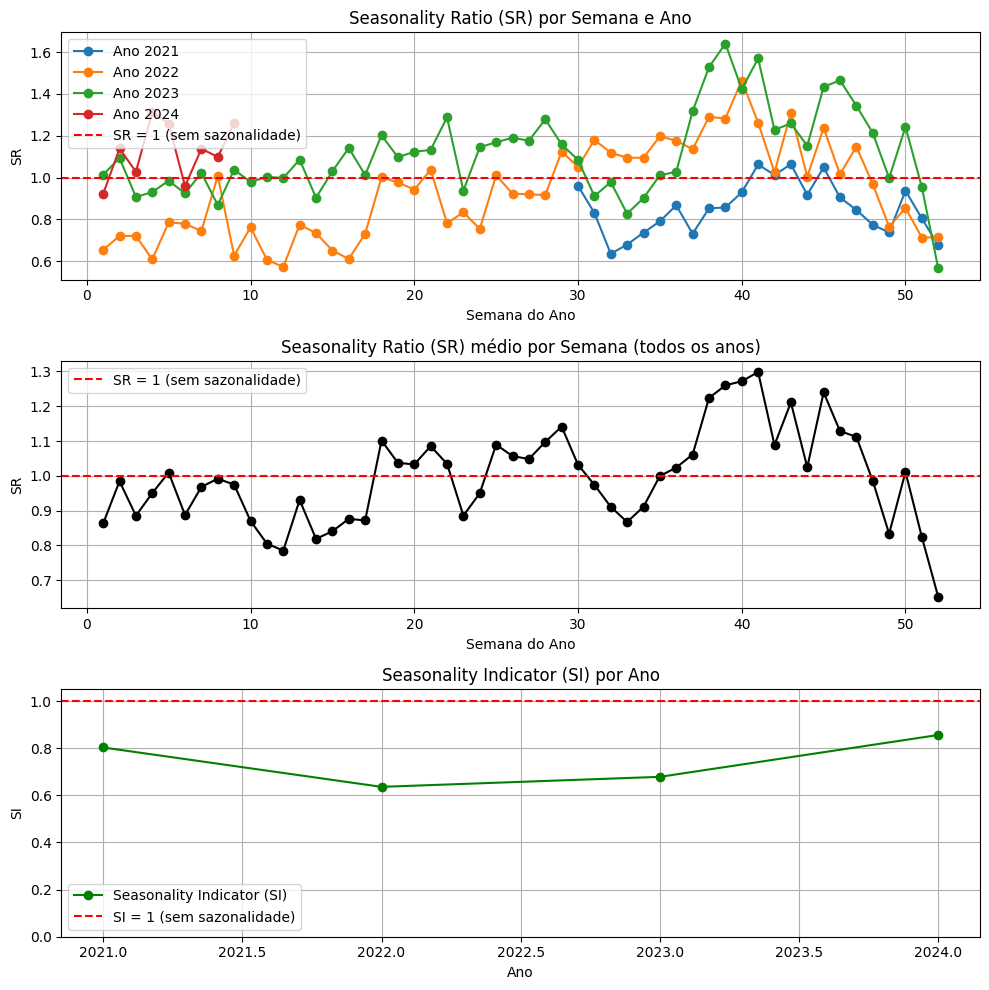

      ano  semana  media_semanal        SR
0    2021      30     106.000000  0.960200
1    2021      31      91.714286  0.830793
2    2021      32      70.142857  0.635388
3    2021      33      75.000000  0.679387
4    2021      34      81.285714  0.736326
..    ...     ...            ...       ...
131  2024       5     138.857143  1.257836
132  2024       6     105.815393  0.958527
133  2024       7     125.571429  1.137487
134  2024       8     121.285714  1.098665
135  2024       9     139.000000  1.259130

[136 rows x 4 columns]
 
    semana        SR
0        1  0.862850
1        2  0.984299
2        3  0.885144
3        4  0.950279
4        5  1.009374
5        6  0.887174
6        7  0.967964
7        8  0.991689
8        9  0.974434
9       10  0.870262
10      11  0.804911
11      12  0.784853
12      13  0.930436
13      14  0.818499
14      15  0.840498
15      16  0.876085
16      17  0.871556
17      18  1.101253
18      19  1.037197
19      20  1.032668
20      21  1.085

In [78]:

df_diario = df_corrigido_final['count_8'].reset_index()
df_diario.columns = ['datetime', 'count_8']
df_sr, df_sr_media, df_si = calcular_sr_si(df_diario, coluna='count_8', plotar=True)

print(df_sr)
print(' ')        
print(df_sr_media)    
print(' ')  
print(df_si)                    


### Com a decomposição STL

In [63]:
y = df_corrigido_final['count_8']
y_boxcox = boxcox(y, lmbda=0)
best_lambda = boxcox_lambda(y, method='guerrero', season_length=7)
y_boxcox = boxcox(y, best_lambda)

In [64]:
inv_boxcox(y_boxcox, best_lambda).round(0)

array([106.,  91., 115., 104., 107.,  77.,  71.,  77.,  88.,  67.,  69.,
        77.,  62.,  59.,  69.,  78.,  77.,  77.,  81.,  64.,  68.,  80.,
        74.,  92.,  78.,  88.,  87.,  54.,  96.,  93.,  99.,  85.,  75.,
        85.,  78.,  96.,  93.,  72.,  92.,  84., 104., 106., 119.,  56.,
        63.,  93., 106.,  68.,  95.,  84.,  94., 105., 113.,  87.,  75.,
        87.,  98.,  99.,  88., 101.,  87., 103.,  89.,  95.,  95., 101.,
       127.,  93., 111.,  98.,  93., 123., 110., 132., 131., 124., 100.,
       101., 134., 138.,  90.,  72., 123., 116., 109., 102., 141., 139.,
       133., 113.,  69., 125.,  96.,  89.,  88., 141., 119.,  71., 105.,
       118., 134., 135., 124., 116.,  68., 115., 128., 125.,  93., 109.,
       103.,  55.,  86.,  97., 110., 132.,  77., 112.,  57.,  68.,  89.,
       114.,  59.,  97., 111.,  52.,  76.,  99.,  80.,  54.,  72.,  64.,
        84., 117.,  93., 116., 123., 117., 110.,  72.,  93., 113.,  39.,
        51.,  47.,  34., 160., 177., 106.,  67.,  6

In [65]:
stl = STL(y_boxcox, period=7)
decomp_stl = stl.fit()
df_decomp_stl = pd.DataFrame({
    'observed': inv_boxcox(decomp_stl.observed, best_lambda),
    'trend': inv_boxcox(decomp_stl.trend, best_lambda),
    'seasonal': inv_boxcox(decomp_stl.seasonal, best_lambda),
    'residual': inv_boxcox(decomp_stl.resid, best_lambda)
}, index=df_corrigido_final.index)

df_decomp_stl.head(15)

,observed,trend,seasonal,residual
datetime,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212
2021-08-02,91.000214,102.713977,1.000253,0.997709
2021-08-03,115.000008,97.815446,1.001012,1.001506
2021-08-04,104.000168,93.293179,1.001222,1.000582
2021-08-05,107.000084,89.126421,1.003456,0.999613
2021-08-06,76.999878,85.291393,0.997168,1.000820
2021-08-07,70.999977,81.773340,0.996818,1.000243
2021-08-08,76.999878,78.444116,1.000004,0.999615
2021-08-09,87.999878,75.468710,1.000668,1.002358


,observed,trend,seasonal,residual,seasonadjust
datetime,,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212,0.981447
2021-08-02,91.000214,102.713977,1.000253,0.997709,0.885957
2021-08-03,115.000008,97.815446,1.001012,1.001506,1.175684
2021-08-04,104.000168,93.293179,1.001222,1.000582,1.114767
2021-08-05,107.000084,89.126421,1.003456,0.999613,1.200543
...,...,...,...,...,...
2024-02-25,75.000328,110.879568,0.991905,1.001177,0.676413
2024-02-26,112.000572,109.623797,1.001155,0.999167,1.021681
2024-02-27,136.999756,108.594895,1.002685,1.000511,1.261567


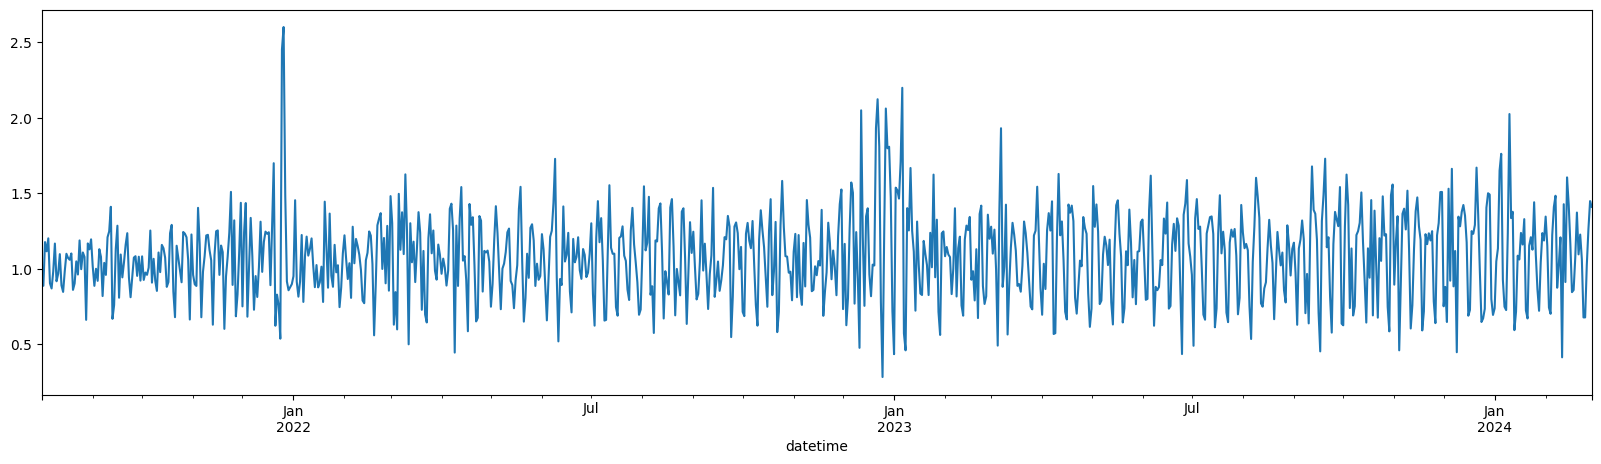

In [66]:
df_season_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed / df_decomp_stl.trend)
df_season_stl.seasonadjust.plot(figsize=(20,5));
df_season_stl

In [67]:
df_sem_tendencia = pd.DataFrame({
    'datetime': df_decomp_stl.index,
    'count_8': df_season_stl['seasonadjust']
})


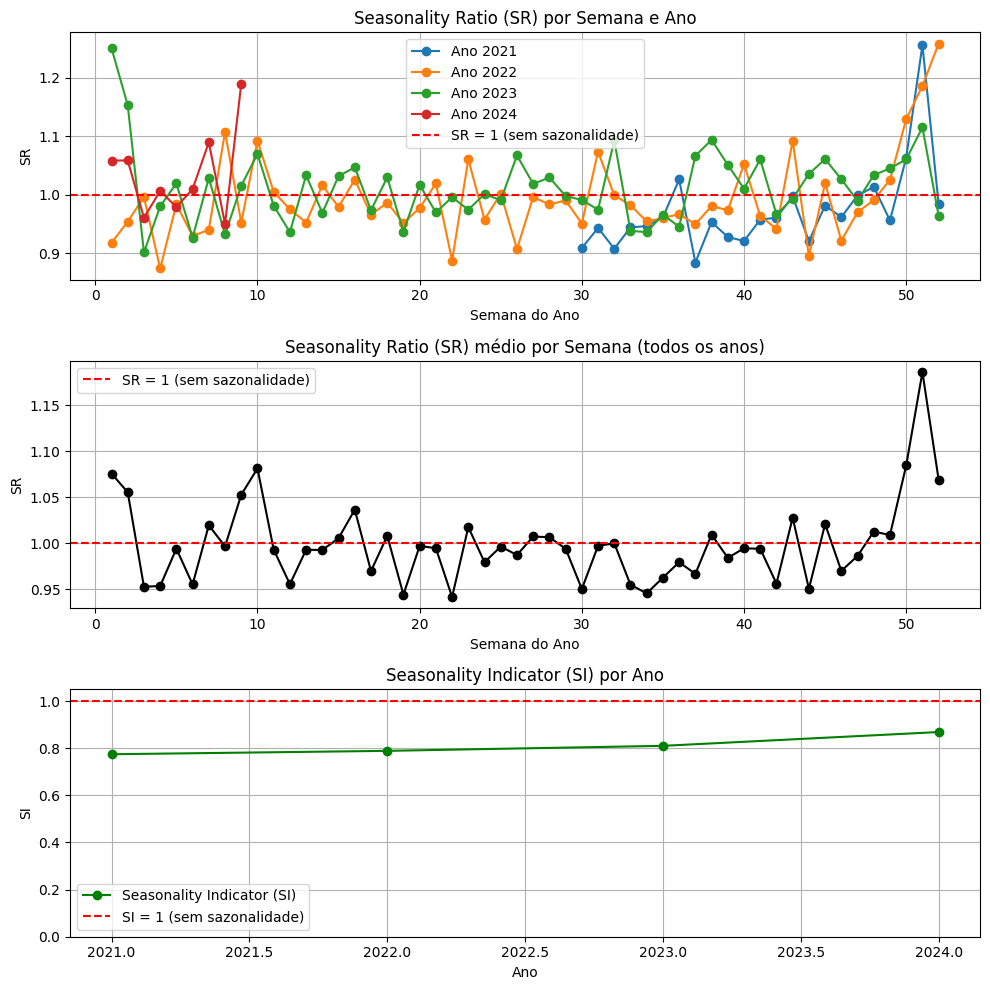

      ano  semana  media_semanal        SR
0    2021      30       0.981447  0.908936
1    2021      31       1.018511  0.943263
2    2021      32       0.980245  0.907824
3    2021      33       1.019412  0.944097
4    2021      34       1.022101  0.946587
..    ...     ...            ...       ...
131  2024       5       1.057127  0.979025
132  2024       6       1.090329  1.009774
133  2024       7       1.176713  1.089776
134  2024       8       1.025769  0.949985
135  2024       9       1.284917  1.189986

[136 rows x 4 columns]


In [68]:
df_sr, df_sr_media_semana, df_si = calcular_sr_si(df_sem_tendencia, coluna='count_8', plotar=True)
print(df_sr)


### Indice de Gini

In [73]:
def curva_lorenz_gini(df, coluna_contagem):
    """
    Calcula e fazer grafico da Curva de Lorenz semanal para a coluna especificada,
    calcula o índice de Gini e mostra as tabelas organizadas.

    Parâmetros:
    - df: DataFrame com a coluna datetime e a coluna de contagem
    - coluna_contagem: nome da coluna (string) para análise, ex: 'count_8'

    Retorna:
    - gini: valor do índice de Gini calculado
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['semana'] = df['datetime'].dt.isocalendar().week

    # Média por semana (ordenada por semana)
    media_por_semana = df.groupby('semana')[coluna_contagem].mean().sort_index()

    # Média ordenada para Curva de Lorenz
    media_ordenada = media_por_semana.sort_values()

    n = len(media_ordenada)
    xi = np.arange(1, n + 1) / n
    yi = np.cumsum(media_ordenada) / np.sum(media_ordenada)

    # Criar DataFrames organizados para mostrar
    tabela_media = pd.DataFrame({
        'semana': media_por_semana.index,
        f'média {coluna_contagem}': media_por_semana.values
    })

    tabela_lorenz = pd.DataFrame({
        'semana (ordenada por média)': media_ordenada.index,
        f'média {coluna_contagem} (ordenada)': media_ordenada.values,
        'proporção acumulada das semanas (Xi)': xi,
        'proporção acumulada da procura (Yi)': yi
    })

    print("\nValores para Curva de Lorenz (ordenados por média):")
    print(tabela_lorenz.to_string(index=False))

    # Cálculo do índice de Gini
    xi_full = np.insert(xi, 0, 0)
    yi_full = np.insert(yi, 0, 0)
    area_below_curve = np.trapz(yi_full, xi_full)
    gini = 1 - 2 * area_below_curve

    print(f'\nÍndice de Gini semanal para {coluna_contagem}: {gini:.4f}')

    # Plot da Curva de Lorenz
    plt.figure(figsize=(8, 8))
    plt.plot(xi, yi, label=f'Curva de Lorenz semanal ({coluna_contagem})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Igualdade perfeita')
    plt.xlabel('Proporção acumulada das semanas')
    plt.ylabel('Proporção acumulada da procura')
    plt.title(f'Curva de Lorenz – Sazonalidade Semanal (média anual)\nÍndice de Gini = {gini:.4f}')
    plt.legend()
    plt.grid(True)
    plt.axis('square')
    plt.tight_layout()
    plt.show()

    return gini



Valores para Curva de Lorenz (ordenados por média):
 semana (ordenada por média)  média count_8 (ordenada)  proporção acumulada das semanas (Xi)  proporção acumulada da procura (Yi)
                          52                 71.919404                              0.019231                             0.012579
                          12                 86.642857                              0.038462                             0.027733
                          11                 88.857143                              0.057692                             0.043274
                          14                 90.357143                              0.076923                             0.059077
                          51                 90.927659                              0.096154                             0.074981
                          49                 91.987993                              0.115385                             0.091069
                          15         

C:\Users\joana\AppData\Local\Temp\ipykernel_20848\14051090.py:46: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



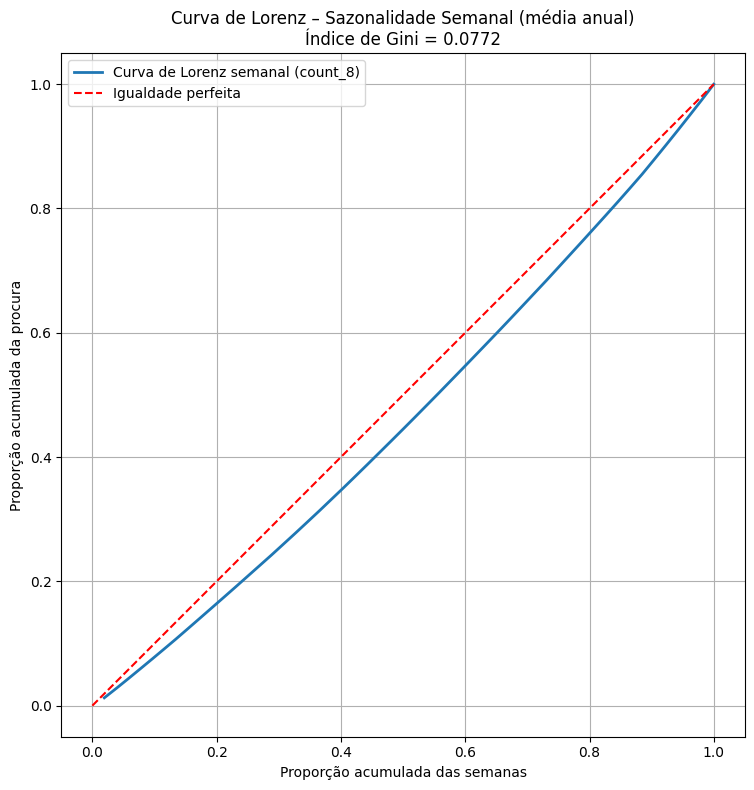


Valores para Curva de Lorenz (ordenados por média):
 semana (ordenada por média)  média count_8 (ordenada)  proporção acumulada das semanas (Xi)  proporção acumulada da procura (Yi)
                          22                  1.016800                              0.019231                             0.018122
                          19                  1.019609                              0.038462                             0.036295
                          34                  1.021076                              0.057692                             0.054494
                          44                  1.026380                              0.076923                             0.072787
                           3                  1.028780                              0.096154                             0.091123
                           4                  1.029647                              0.115385                             0.109474
                          33         

C:\Users\joana\AppData\Local\Temp\ipykernel_20848\14051090.py:46: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



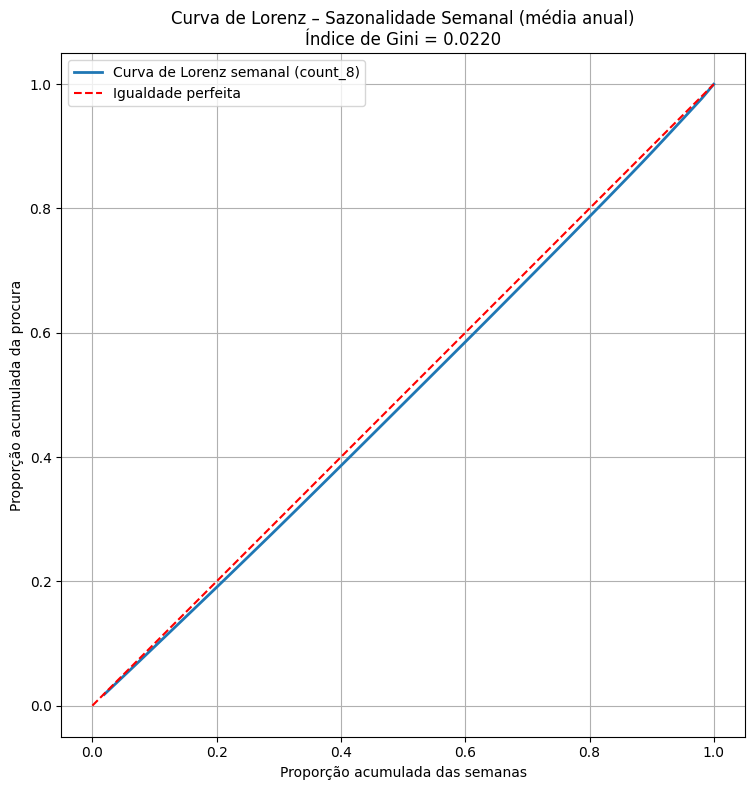

In [74]:

gini1 = curva_lorenz_gini(df_diario, 'count_8')
gini2 = curva_lorenz_gini(df_sem_tendencia, 'count_8')


Dataframe original (sem STL) tem alguma desiguldade mas bastante baixa. Existe alguma sazonalidade, mas não muito forte. 
Dataframe do STl tem uma distribuição quase uniforme. 

In [87]:
def decomposicao_gini_por_estacao(df, contador):

    # Mapear as estações do ano
    def get_estacao(mes):
        if mes in [12, 1, 2]:
            return 'Inverno'
        elif mes in [3, 4, 5]:
            return 'Primavera'
        elif mes in [6, 7, 8]:
            return 'Verão'
        else:
            return 'Outono'
    
    df['Estacao'] = df['datetime'].dt.month.apply(get_estacao)
    df['semana'] = df['datetime'].dt.isocalendar().week

    # Índice de Gini auxiliar para um array de valores
    def gini_coefficient(x):
        x = np.array(x)
        if np.amin(x) < 0:
            x -= np.amin(x)  # corrigir negativos
        x = np.sort(x)
        n = len(x)
        index = np.arange(1, n+1)
        return (np.sum((2 * index - n - 1) * x)) / (n * np.sum(x))

    # 1. Média semanal global (todos dados)
    media_global = df.groupby('semana')[contador].mean().sort_index()
    media_global_ordenada = media_global.sort_values()
    n = len(media_global_ordenada)
    xi = np.arange(1, n + 1) / n
    yi = np.cumsum(media_global_ordenada) / np.sum(media_global_ordenada)
    xi_full = np.insert(xi, 0, 0)
    yi_full = np.insert(yi, 0, 0)
    area_below_curve = np.trapz(yi_full, xi_full)
    gini_global = 1 - 2 * area_below_curve

    # 2. Calcular G_k, S_k e R_k para cada estação
    estacoes = ['Inverno', 'Primavera', 'Verão', 'Outono']
    resultados = []
    for est in estacoes:
        df_est = df[df['Estacao'] == est]
        # Média semanal da estação
        media_est = df_est.groupby('semana')[contador].mean().sort_index()
        # S_k = proporção do total anual nesta estação
        S_k = media_est.sum() / media_global.sum()
        # G_k = índice de Gini da estação (média semanal ordenada)
        media_est_ord = media_est.sort_values()
        G_k = gini_coefficient(media_est_ord.values)
        # R_k = correlação entre média semanal da estação e média global (ordenadas pelas semanas)
        semanas_comuns = media_est.index.intersection(media_global.index)
        if len(semanas_comuns) > 1:
            R_k = np.corrcoef(media_est.loc[semanas_comuns], media_global.loc[semanas_comuns])[0, 1]
        else:
            R_k = 0  # correlação não definida para poucas semanas
        contrib = S_k * G_k * R_k
        resultados.append({'Estação': est, 'G_k': G_k, 'S_k': S_k, 'R_k': R_k, 'Contribuição': contrib})

    df_result = pd.DataFrame(resultados)
    soma_contribuicoes = df_result['Contribuição'].sum()

    return gini_global, soma_contribuicoes, df_result


In [84]:
def plot_gini_decomposition(tabela):
    # Gráfico 1: Contribuições por estação
    plt.figure(figsize=(10, 5))
    plt.bar(tabela['Estação'], tabela['Contribuição'], color='skyblue')
    plt.title('Contribuição Marginal das Estações para a Sazonalidade Total (Índice de Gini)')
    plt.ylabel('Contribuição')
    plt.xlabel('Estação do Ano')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: G_k, S_k e R_k por estação
    x = np.arange(len(tabela['Estação']))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, tabela['G_k'], width, label='$G_k$ (Sazonalidade interna)', color='coral')
    ax.bar(x, tabela['S_k'], width, label='$S_k$ (Peso na procura)', color='mediumseagreen')
    ax.bar(x + width, tabela['R_k'], width, label='$R_k$ (Correlação com total)', color='royalblue')

    ax.set_xticks(x)
    ax.set_xticklabels(tabela['Estação'])
    ax.set_ylabel('Valores')
    ax.set_title('Componentes da Decomposição Marginal do Índice de Gini por Estação')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [92]:
gini_total, gini_decomp, tabela_diario = decomposicao_gini_por_estacao(df_diario, 'count_8')
print(f'Índice de Gini total: {gini_total:.4f}')
print(f'Soma da decomposição marginal do Gini: {gini_decomp:.4f}')
print(tabela_diario)

Índice de Gini total: 0.0772
Soma da decomposição marginal do Gini: 0.0539
     Estação       G_k       S_k       R_k  Contribuição
0    Inverno  0.076203  0.245657  0.655903      0.012278
1  Primavera  0.077328  0.251662  0.897179      0.017460
2      Verão  0.050551  0.271158  0.904582      0.012399
3     Outono  0.059422  0.313048  0.631377      0.011745


C:\Users\joana\AppData\Local\Temp\ipykernel_20848\3601886327.py:35: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



G_k: Primavera e Inverno têm sazonalidade ligeiramente mais alta internamente (distribuição semanal mais desigual dentro da estação).

S_k: Outono e Verão representam maior parte da procura anual (27-31% cada).

R_k: Primavera e Verão estão mais correlacionados com o padrão global (valores perto de 0.9), ou seja, o padrão sazonal destas estações segue bem a sazonalidade global.

Contribuição: Primavera tem maior contribuição para a sazonalidade total, seguida por Verão, Inverno e Outono.

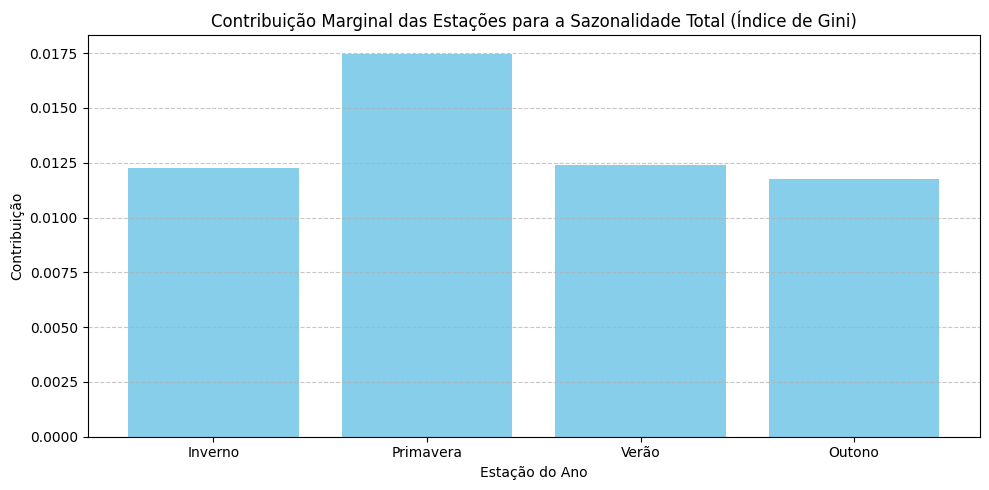

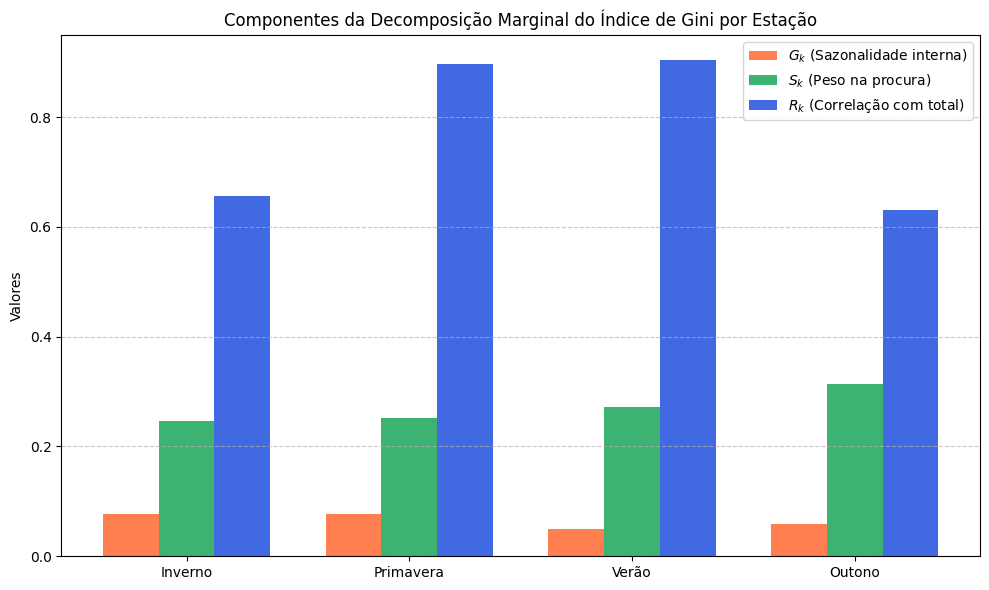

In [93]:
plot_gini_decomposition(tabela_diario)

In [94]:
gini_total, gini_decomp, tabela_sem_tendencia = decomposicao_gini_por_estacao(df_sem_tendencia, 'count_8')
print(f'Índice de Gini total: {gini_total:.4f}')
print(f'Soma da decomposição marginal do Gini: {gini_decomp:.4f}')
print(tabela_sem_tendencia)

Índice de Gini total: 0.0220
Soma da decomposição marginal do Gini: 0.0219
     Estação       G_k       S_k       R_k  Contribuição
0    Inverno  0.045935  0.275380  0.755044      0.009551
1  Primavera  0.017252  0.268257  0.767948      0.003554
2      Verão  0.018408  0.265844  0.658136      0.003221
3     Outono  0.033901  0.269328  0.607429      0.005546


C:\Users\joana\AppData\Local\Temp\ipykernel_20848\3601886327.py:35: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



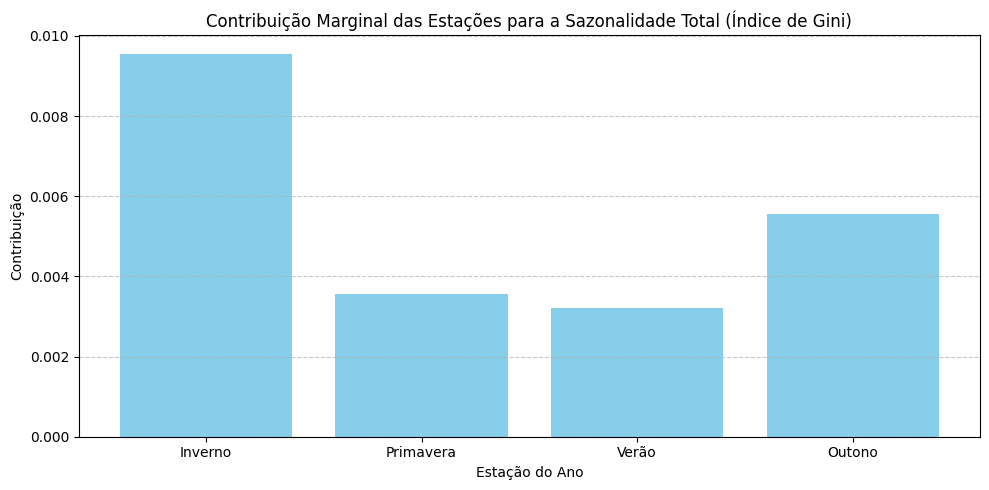

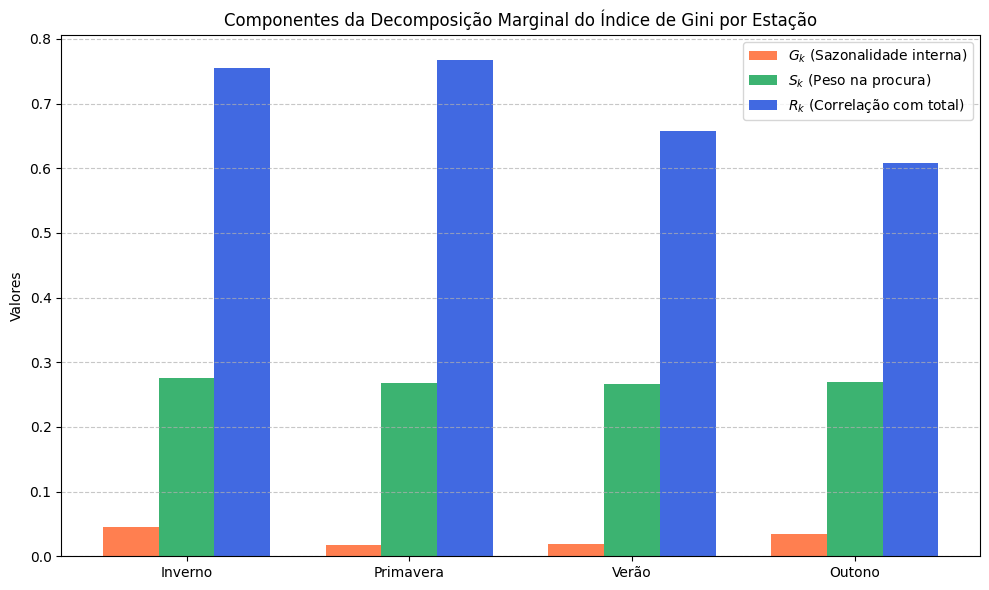

In [95]:
plot_gini_decomposition(tabela_sem_tendencia)

Inverno e o Outono contribuem mais para a sazonalidade residual, refletindo maior variação na procura nestas épocas. 

A decomposição STL, ao remover a tendência, evidencia que o inverno é a estação com maior sazonalidade na procura, provavelmente devido às condições meteorológicas adversas que limitam a atividade. Sem a remoção da tendência, a primavera parece mais influente, refletindo também o efeito do crescimento geral ao longo dos anos.

In [90]:
def calcula_rme(tabela, gini_total):
    tabela = tabela.copy()
    # Calcular RME_k segundo a fórmula: RMEk = (S_k * G_k * R_k) / G_Y - S_k
    tabela['RME_k'] = (tabela['S_k'] * tabela['G_k'] * tabela['R_k']) / gini_total - tabela['S_k']
    return tabela


In [97]:
tabela_com_rme = calcula_rme(tabela_diario, gini_total)
print(tabela_com_rme)

     Estação       G_k       S_k       R_k  Contribuição     RME_k
0    Inverno  0.076203  0.245657  0.655903      0.012278  0.311722
1  Primavera  0.077328  0.251662  0.897179      0.017460  0.540922
2      Verão  0.050551  0.271158  0.904582      0.012399  0.291716
3     Outono  0.059422  0.313048  0.631377      0.011745  0.220116


Primavera é a estação que mais contribui para a sazonalidade, enquanto outono é a que contribui menos. 

In [96]:
tabela_com_rme = calcula_rme(tabela_sem_tendencia, gini_total)
print(tabela_com_rme)


     Estação       G_k       S_k       R_k  Contribuição     RME_k
0    Inverno  0.045935  0.275380  0.755044      0.009551  0.158189
1  Primavera  0.017252  0.268257  0.767948      0.003554 -0.106921
2      Verão  0.018408  0.265844  0.658136      0.003221 -0.119635
3     Outono  0.033901  0.269328  0.607429      0.005546 -0.017559


Primavera, Verão e Outono atenuam a sazonalidade porque tem valores negativos. O Inverno é a estação que contribui mais para a sazonalidade. 